# AutoEncoder



## 1.환경준비

### 1) 라이브러리 로딩

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import tensorflow.keras as keras
from keras.backend import clear_session
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense

2025-05-02 10:50:39.795990: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-02 10:50:39.800131: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-02 10:50:39.877404: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-02 10:50:39.909168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746150639.974678   25855 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746150639.98

### 2) 필요 함수들 생성

#### ① reconstruction error plot

> * input과 output의 차이(mse)를 계산하고
* 시각화 합니다.



In [2]:
def recon_err_plot(x, x_pred, y, threshold=0):
    mse = np.mean(np.power(x - x_pred, 2), axis=1)
    error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y})
    error_df = error_df.reset_index()

    groups = error_df.groupby('True_class')
    fig, ax = plt.subplots()
    for name, group in groups:
        ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
                label= "Abnormal" if name == 1 else "Normal")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for different classes")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.show()

    return error_df

#### ② precision, recall, f1 curve

> * sklearn에서는 precision, recall curve만 제공됩니다.
* 그래서, f1 curve도 추가해서 구하고, plot을 그립니다.



In [3]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def prec_rec_f1_curve(y, score, pos = 1) :
    precision, recall, thresholds  = precision_recall_curve(y, score, pos_label=1)
    f1 = 2 / (1/precision + 1/recall)

    plt.plot(thresholds, np.delete(precision, -1), label = 'precision')
    plt.plot(thresholds, np.delete(recall, -1), label = 'recall')
    plt.plot(thresholds, np.delete(f1, -1), label = 'f1')
    plt.xlabel('Anomaly Score')
    plt.legend()
    plt.grid()
    plt.show()

    return precision, recall, f1, thresholds

#### ③ threshold로 잘랐을 때, 분류 평가 함수


In [4]:
from sklearn.metrics import confusion_matrix, classification_report

def classification_report2(y, pred, thresholds):
    pred_temp = np.where(pred > thresholds , 1, 0)

    print('< confusion matrix >\n')
    print(confusion_matrix(y, pred_temp))
    print('\n' + '='*60 + '\n')

    print('< classification_report >\n')
    print(classification_report(y, pred_temp))

    return confusion_matrix(y, pred_temp)

#### ④ DL 학습곡선 그리기


In [5]:
def plot_learning_curve(history) :
    plt.plot(history['loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

### 3) 데이터셋 불러오기

![](https://keralakaumudi.com/web-news/en/2020/04/NMAN0141956/image/paper-mill.1.582102.jpg)

In [6]:
# 공정 데이터 불러오기
path = "processminer2.csv"
data = pd.read_csv(path)
data.head()

,y,time,x1,x2,x3,x4,x5,x6,x7,x8,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
0,0.0,5/1/99 0:00,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,29.984624,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076
1,0.0,5/1/99 0:02,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,29.984624,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083
2,0.0,5/1/99 0:04,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,29.984624,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090
3,0.0,5/1/99 0:06,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,29.984624,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097
4,0.0,5/1/99 0:08,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,29.984624,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105


In [7]:
date2 = data.copy()
date2['time'] = pd.to_datetime(data.time, format = '%m/%d/%y %H:%M')
date2['day'] = date2['time'].dt.day
date2.loc[date2['y']==1].groupby('day', as_index=False)['y'].count()

,day,y
0,1,2
1,2,12
2,3,6
3,4,22
4,5,22
5,6,7
6,7,4
7,8,4
8,9,2
9,10,2


## 2.데이터 준비

### 1) 불필요한 변수 제거

불필요한 변수 제거 : time

In [8]:
data.drop('time', axis=1, inplace=True)

In [9]:
data.shape

(18274, 60)

### 2) 데이터 분할

* x, y 분할

In [10]:
target = 'y'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

In [11]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 6000, random_state = 2022)

### 3) 스케일링 : Standardization

* 학습은 x_train_0을 사용하므로,
* 스케일링도 x_train_0 기준으로 수행


In [12]:
# 스케일링 fitting
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

* 학습용 Normal Data

In [18]:
x_train0 = x_train[y_train == 0]

## 3.모델링 실습
* 원하는 구조로 모델을 설계하고 학습해 봅시다.
* 혹은 아래와 같이 구성해도 좋습니다.
    * Input(59)
    * Dense(16)
    * Dense(8)
    * Dense(16)
    * Dense(59)


### 1) Auto Encoder
* 모델 설계

In [19]:
input_dim = x_train0.shape[1]

* 학습

In [20]:
clear_session()
autoencoder = Sequential([Dense(32, input_shape = (input_dim,), activation='relu'),
                         Dense(16, activation='relu'),
                         Dense(32, activation='relu'),
                         Dense(input_dim, activation='relu')])
autoencoder.summary()

/home/clip968/miniforge3/envs/pytorch/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 59)             │         1,947 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,939 (19.29 KB)

 Trainable params: 4,939 (19.29 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(x=x_train0, y=x_train0, epochs=50, batch_size=64, validation_split=.2).history

Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.9352 - val_loss: 0.8292
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 0.8052 - val_loss: 0.7841
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 0.7908 - val_loss: 0.7558
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 0.7115 - val_loss: 0.7376
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 0.7197 - val_loss: 0.7250
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 0.6997 - val_loss: 0.7151
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 0.6870 - val_loss: 0.7032
Epoch 8/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6786 - val_loss: 0.6905
Epoch 9/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 0.6729 - val_loss: 0.6796
Epoch 10/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 0.6731 - val_loss: 0.6745
Epoch 11/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 0.6751 - val_loss: 0.6715
Epoch 12/50
152/152 ━━━━━━━━━━━━━━

### 2) 분류에 대한 평가

* validation 셋으로 예측하고 reconstruction error로 평가해 봅시다.

In [26]:
pred = autoencoder.predict(x_val)

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step


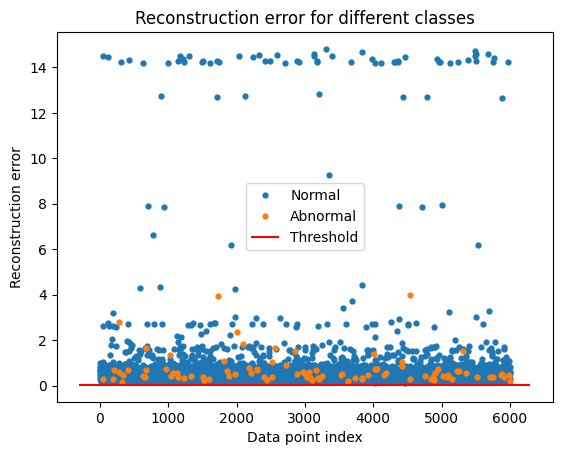

In [27]:
result = recon_err_plot(x_val, pred, y_val, .03)

* thresholds 값을 조절하면서, precision, recall, f1 score 그래프를 그려 봅시다.

/tmp/ipykernel_25855/3279574342.py:6: RuntimeWarning: divide by zero encountered in divide
  f1 = 2 / (1/precision + 1/recall)


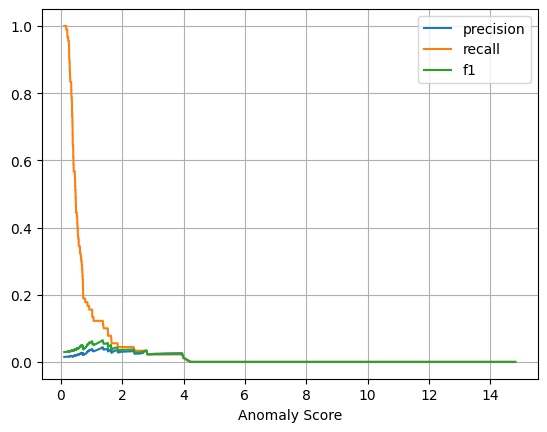

In [28]:
precision, recall, f1, thresholds = prec_rec_f1_curve(result['True_class'], result['Reconstruction_error'])

* f1 score를 가장 높이는 thresholds 값을 찾고 평가해 봅시다.

In [29]:
thres_f1_max = thresholds[np.argmax(f1)]
thres_f1_max

1.3676080500254943

## 4.비즈니스 관점에서의 모델 평가

> * 한 롤로 종이를 말다가 찢어지는 사고가 하루에 한번 정도 발생.
* 이때마다 공정 중단 및 수율 저하 등, 평균적으로 100백만원의 손실이 발생
* 이를 사전에 감지하는 것은 굉장히 어려움. 이런 사고를 5%만 감소시키더라도 회사 입장에서는 상당한 비용 절감효과 예상.
* 장애가 예상된다면, 속도를 줄여 장애를 예방할 수 있다. 단, 속도를 줄이면 생산성이 저하되므로, 1회당 평균 3만원의 손실이 발생됩니다.


### 1) 비즈니스 기대가치 매트릭스

In [ ]:
bv = np.array([[0,3],[100,3]])
bv

### 2) cost 계산

* 예측값에 대한 cost 계산

In [ ]:
np.sum(cm * bv)

### 3) threshold 값을 조정하면서 cost를 계산해 봅시다.

#### ① 비교대상(Base Cost) 계산

* 1) 예방활동을 하지 않고, 장애 발생에 대한 조치 비용 계산 ==> 계산가능
* 2) 현재 수행중인 예방활동 비용 + 장애발생 비용 계산 ==> 이 부분은 현재 모르므로 여기서는 다루지 않음

In [ ]:
base_cost = result['True_class'].sum() * 100
base_cost

#### ② threshold 값 조정하며 Cost 계산

In [ ]:
cost = []
for v in thresholds :
    y_pred = np.where(result['Reconstruction_error']> v, 1, 0)
    cm = confusion_matrix(result['True_class'], y_pred)
    cost.append(np.sum(cm * bv))

cost = np.array(cost)

### 4) 비교 그래프를 그려 봅시다.

In [ ]:
thresholds[np.argmin(cost)]

In [ ]:
min_tres = round(thresholds[np.argmin(cost)],5)

print(f'Anomaly Score : {min_tres},  Min Cost : {min(cost)}' )
plt.figure(figsize = (15, 8))
plt.plot(thresholds, cost)

plt.axhline(base_cost, color = 'r', linestyle = ":")
plt.axhline(min(cost), color = 'g', linestyle = ":")
plt.axvline(min_tres, color = 'g', linestyle = ":")

plt.text(max(thresholds)/2, base_cost-100, f"base cost : {base_cost}", color = 'r')
plt.text(max(thresholds)/2, min(cost)-100, f"min cost : {min(cost)}", color = 'g')

plt.ylim(7500, 10000)
plt.xlabel("Anomaly Score")
plt.ylabel("Cost")
plt.show()